## Model Training

In [1]:
import os, sys, time, logging, configparser
sys.path.append('\\'.join(os.getcwd().split('\\')[:-2]))
sys.path.append('\\'.join(os.getcwd().split('\\')))
import warnings
warnings.filterwarnings("ignore")
# os.environ['CUDA_VISIBLE_DEVICES']='1'
from XAE.dataset import MNIST
from XAE.util import init_params, calculate_sharpness
from XAE.sampler import gaus
from XAE.logging_daily import logging_daily
import XAE.fid as fid

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import import_module
from random import sample

In [2]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

log = None
# logger = logging_daily('./config/log_info.yaml')
# log = logger.get_logging()
# log.setLevel(logging.INFO)

cfg = configparser.ConfigParser()
cfg.read('./config/train_config.cfg')

cur_model = getattr(import_module('train'), cfg['train_info']['model_name'])

In [3]:
mm = cur_model(cfg, log, device = device, verbose = 0)
# mm.train()

## Model Load

In [4]:
mm.load('./%s' % (cfg['path_info']['save_path']))

In [5]:
batch_size = 100
test_data = MNIST(cfg['path_info']['data_home'], train = False, label = True)
test_generator = torch.utils.data.DataLoader(test_data, batch_size, num_workers = 5, shuffle = False, pin_memory=True, drop_last=True)
n = len(test_generator)

In [6]:
test_iter = iter(test_generator)
# encoded_label = np.zeros((n*batch_size, 10))
true_label = np.zeros(n*batch_size)
lab_t = torch.Tensor(range(10))
for i in range(n):
    img, lab = next(test_iter)
    true_label[(i*batch_size):((i+1)*batch_size)] = (lab_t*lab).sum(dim=1).detach().numpy()
#     encoded_label[(i*batch_size):((i+1)*batch_size),:] = mm.encode(img.to(device))[:,0:10].to('cpu').detach().numpy()
    
# labeled_class = cfg['train_info']['labeled_class'].replace(' ', '').split(',')
# labeled_class = [int(i) for i in labeled_class]
# test_class = cfg['train_info']['test_class'].replace(' ', '').split(',')
# test_class = [int(i) for i in test_class]

## Test Sample plot

In [7]:
target = []
n = len(true_label)
for i in range(10):
    target_d = np.arange(n)[true_label == i]
    target.append(target_d[np.random.choice(target_d.shape[0], 1, replace = False)])
target
x = torch.Tensor(np.concatenate([np.array(test_data[i][0]) for i in target])).unsqueeze(1).to(device)
z = mm.encode(x)
recon = mm.decode(z).squeeze(1).detach().to('cpu').numpy()
# z = z.detach().to('cpu').numpy()

In [8]:
z.shape

torch.Size([10, 10])

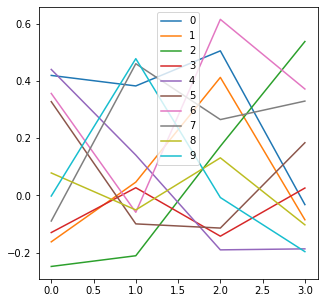

In [9]:
fig, ax = plt.subplots(figsize = (5.0, 5.0))
for i in range(10):
    ax.plot(z[i, 0:mm.y_dim].detach().to('cpu').numpy(), label = "%s" % i)
plt.legend()
plt.show()

In [10]:
sample_data = []

sample_data.append(np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1))
sample_data.append(np.concatenate([recon[i,:,:] for i in range(10)], axis = 1))
sample_data = np.concatenate(sample_data, axis = 0)

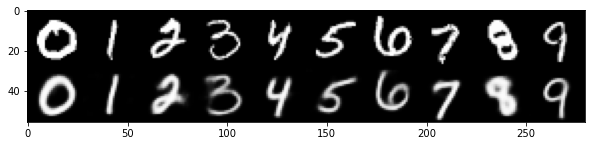

In [11]:
fig = plt.figure(figsize=(10.0,10.0))
plt.imshow(sample_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.show()

# Sample Generation

## 1. Exemplar Generation

In [12]:
exn = 5

In [13]:
zz = torch.cat((torch.zeros(1,mm.z_dim), gaus(exn,mm.z_dim)), dim = 0).to(device)
# new_z = torch.cat((torch.from_numpy(np.eye(10)).type(torch.float32).repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_z = torch.cat((z[:,0:mm.y_dim].repeat_interleave(exn + 1, dim = 0).to(device), zz.repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

In [14]:
new_x.shape

(60, 28, 28)

In [15]:
img_data = []
for i in range(10):
    img_data.append(np.concatenate([test_data[target[i]][0].numpy()[0,:,:]] + [recon[i,:,:]] + [new_x[(exn+1)*i + j] for j in range(exn+1)], axis = 1))
img_data = np.concatenate(img_data, axis = 0)

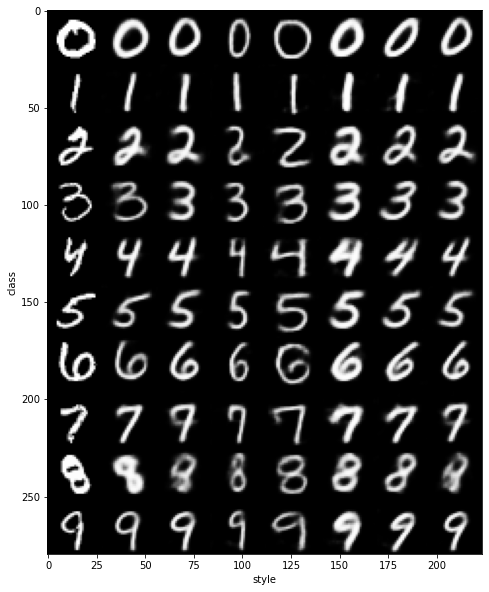

In [16]:
fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()

## 2. Style Transfer

In [17]:
new_z = torch.cat((z[:,:mm.y_dim].repeat_interleave(10, dim = 0), z[:,mm.y_dim:].repeat((10, 1))), dim = 1)
new_x = mm.decode(new_z).squeeze(1).detach().to('cpu').numpy()

In [18]:
img_data = np.ones((28*11, 28*11))*-1
img_data[:28,28:] = np.concatenate([test_data[i][0].numpy()[0,:,:] for i in target], axis = 1)
for i in range(10):
    img_data[((i+1)*28):((i+2)*28),:28] = test_data[target[i]][0].numpy()[0,:,:]
    img_data[((i+1)*28):((i+2)*28),28:] = np.concatenate(new_x[(10*i):(10*(i+1)),:,:], axis = 1)

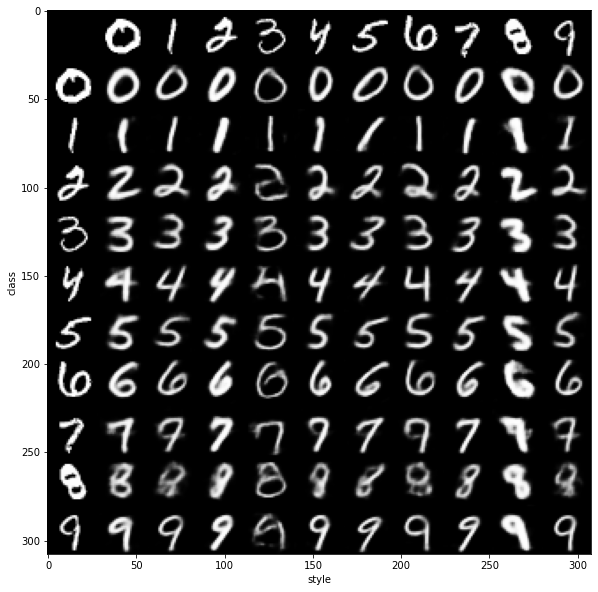

In [19]:
fig, ax = plt.subplots(figsize = (10.0, 10.0))
ax.imshow(img_data, cmap = 'gray', vmin = -1.0, vmax = 1.0)
plt.xlabel('style')
plt.ylabel('class')
plt.show()